In [1]:
%matplotlib widget
import niscope as ni

# Uscita trigger dal signal generator: Pulse Sync

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\Instruments\\QuickSyn')

import RS_SMA100B
from Card_Class import *


import FSL_0010

fsl = FSL_0010.FSL10_synthesizer(device_address='COM31')

SMA100B: Connection successful!
5170R: Available communication!
Channel 0, record 0 samples acquired: 3,000

Channel 0, record 0 samples acquired: 3,000

Channel 2, record 0 samples acquired: 3,000

Channel 2, record 0 samples acquired: 3,000



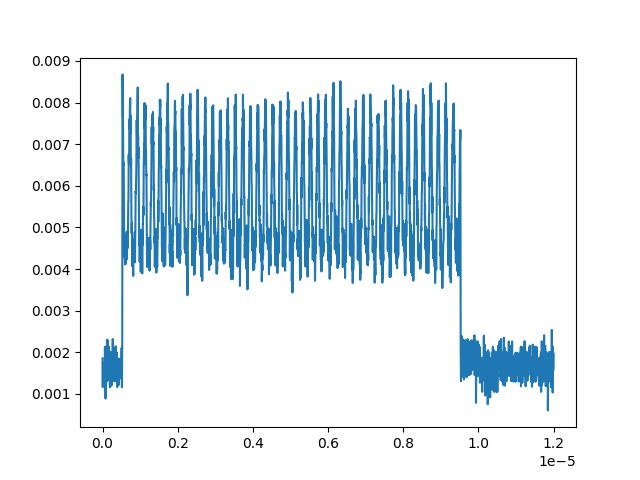

In [15]:
ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

k = 3           # coefficiente per prendere k*1000 punti con la scheda, dunque devo aumentare la pulse width e period

pulse_freq      = 1.005e9
amplitude       = -11                          # Set the amplitude of the signal in dBm
sample_rate     = 250e6 # Maximum Value: 250.0e6
pulse_width     = k*3e-6   # min 5ns                             
pulse_delay     = 0
pulse_period    = k*5e-6   # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')
sGen.RF_freq(pulse_freq)
sGen.RF_lvl_ampl(amplitude)


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate # Maximum Value: 250.0e6

pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)


# FSL-0010
fsl.set_frequency(1) # GHz
fsl.set_output('ON')





with ni.Session("PXI1Slot3") as session: # Name of the device
    session.reset_with_defaults()
    session.channels[0].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # I
    session.channels[2].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # Q
    session.configure_horizontal_timing(
        min_sample_rate     = 250e6, 
        min_num_pts         = int(1000*k), 
        ref_position        = 0, 
        num_records         = 1, 
        enforce_realtime    = True
        )

    session.configure_trigger_digital(
        trigger_source      = 'VAL_PFI_0', 
        slope               = ni.TriggerSlope.POSITIVE, 
        holdoff             = 0, 
        delay               = 0
        )

    with session.initiate():
        waveforms = session.channels[0, 2].fetch()
        #waveforms = session.channels[0].fetch()
    for wfm in waveforms:
        print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))
        print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))

fsl.set_output('OFF')
sGen.pul_state(0)
sGen.RF_state(0)

a = np.array(waveforms[0].samples.tolist())
b = np.array(waveforms[1].samples.tolist())


plt.figure()
#plt.plot(np.arange(len(a))/250e6, 20*np.log10(np.array(a)**2 + np.array(b)**2))
plt.plot(np.arange(len(a))/250e6, np.sqrt(np.array(a)**2 + np.array(b)**2))
#plt.plot(np.arange(len(a))/250e6, np.arctan(np.array(b)/np.array(a)))
#plt.plot(np.arange(len(a))/250e6, np.array(a))
plt.show()

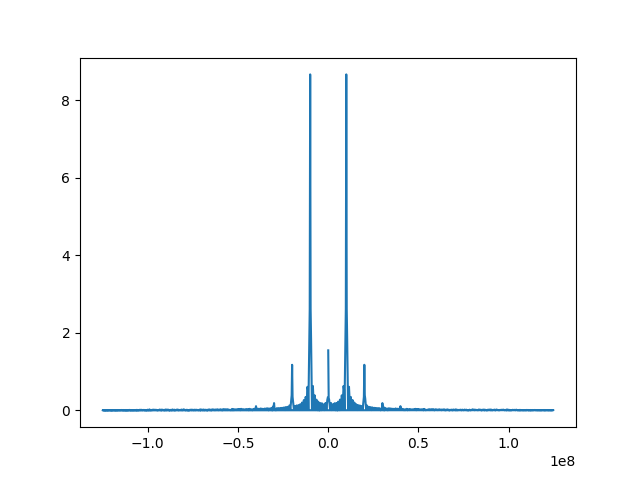

In [40]:
def weight_factor (ft, range_mask):
    # tot_int = np.trapz(ft)
    tot_int = np.sum(ft)
    ft[~range_mask] = 0
    # portion = np.trapz(ft)
    portion = np.sum(ft)

    return tot_int/portion

def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
    N = len(y)
    T = 1/sample_rate
    FT = np.fft.fft(y)
    PHI = np.unwrap(np.angle(FT))

    x = np.arange(len(y))/sample_rate
    freqs = np.fft.fftfreq(N,T) 
    offset = 5e6

    if toggle_plot:
        plt.clf()
        
       
        plt.plot(freqs,np.abs(FT))
        plt.show()
    
data_fft(a, 80e6, sample_rate, True)

- [x] Nel grafico sopra, la frequenza del sig gen è 1,020 GHz. Si notano i due picchetti di 40 = 2 * 20 MHz, ma paiono estremamente piccoli. (Foto sul telefono per il futuro)

Dai test sembra che non servano attenuazioni quando il segnale passa per il mixer, ma è necessaerio capire quanta potenza effettivamente arriva alla scheda per non friggerla.

## DOVREMO fare la CARATTERIZZAZIONE DELL'IQ-MIXER

Studiare range di ampiezze in cui opera e magari anhe range di frequenze.
Studiare Attenuazione che dà?

Nel piano I-q non compare una circonferenza precisa, ma è più un'ellisse. Studiare e magari richiedere.

## LA PRESA DATI PROBABILMENTE SARA' A GIUGNO (2 SETTIMANE CENTRALI)

Preparare i programmi, anche per l'analisi dati in loco per risparmiare tempo.
Relazione su Latex
Giachero dice di premere per fare presa dati a maggio piuttosto che a giugno, ma francamente la vedo dura.
# Sistemare i cicli for nei programmi!! e ritestare il single trigger nei for.

In [51]:
fetched_data = []
fetched_data += [{'I': a, 'Q': b,'ampl' : amplitude, 'f' : pulse_freq }]

#print(fetched_data)

with h5py.File('FIRST_IQ_filters.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
    for j in range(0, len(fetched_data)):
        gp_data = f.create_group(str(j))
        I, Q, ampl, f = fetched_data[j].items()
        gp_data.create_dataset(I[0], data = I[1])
        gp_data.create_dataset(Q[0], data = Q[1])
        gp_data.create_dataset(ampl[0], data = ampl[1] )
        gp_data.create_dataset(f[0], data = f[1])

In [24]:
fetched_data = []
with h5py.File('FIRST_IQ.hdf5', 'r') as f:
    
    for j in range(len(f)):
        dic = {}
        gp = f[str(j)]
        for i, k in gp.items():                         # i = titolo, k = contenuto di ogni entrata del dizionario
            dic[i] = k[()]
        fetched_data += [dic]


#ARCANO  dbm  VS mV

https://www.pianetaradio.it/blog/dbm/ 

In [21]:
fsl.get_frequency()

'1000000000000\n'

In [13]:
fsl.set_output('ON')
fsl.device.write(b'FREQ?\r')


'1000000000000\n'